In [12]:
from fenics import *
import pylab as plt
import matplotlib.pyplot as plt
from create_mesh import create_mesh
%matplotlib inline

i = -1
err = []
j = []

for ij in [1, 2, 3]:
    for n in [2, 4, 8, 16, 32, 64]:
        i = i + 1
        j.append(n)
        # Scaled variables
        a = 1.
        b = 4.*a
        w = b
        E = 1.
        t = 1.
        nu = 0.3
        lmbda = E*nu/((1.+nu)*(1.-2.*nu))
        mu = E/(2.*(1.+nu))
        # CP
        k = 3.-4.*nu
        # DP
        #k = (3.-nu)/(1.+nu)
        
        
        # Define strain and stress
        def eps(u):
            return sym(grad(u))
        
        def sigma(u,lmbda,mu):
            e = eps(u)
            return lmbda*tr(e)*Identity(2) + 2.*mu*e
        
        
        # Define variational problem
        mesh, boundaries = create_mesh(n,a,b,w)
        element = VectorElement('P', triangle, ij)
        V = FunctionSpace(mesh, element)
        u = TrialFunction(V)
        v = TestFunction(V)
        T = Constant((0., 0.))
        f = Constant((0., 0.))
        ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
        
        u_ = TrialFunction(V)
        a_form = inner(sigma(u_,lmbda,mu), eps(v))*dx
        L_form = dot(T,v)*ds(2) + dot(f,v)*dx
        
        # Define a complex expression: Exact solution for a plate with hole
        #!python
        def exact_solution(a,mu,k):
            r = Expression("sqrt(pow(x[0],2)+pow(x[1],2))")
            theta = Expression("atan2(x[1],x[0])")
            u_ex = Expression(
                ("(t*a)/(8*G)*((r/a)*(k+1)*cos(theta)+2*a/r*((1+k)*cos(theta)+cos(3*theta))-2*pow(a/r,3)*cos(3*theta))",
                 "(t*a)/(8*G)*((r/a)*(k-3)*sin(theta)+2*a/r*((1-k)*sin(theta)+sin(3*theta))-2*pow(a/r,3)*sin(3*theta))"),
                a=a,G=mu,r=r,theta=theta,k=k,t=t,degree=3)
            return u_ex
        uex = exact_solution(a,mu,k)
        
        
        def boundary(x, on_boundary):
            return on_boundary
        
        bc = DirichletBC(V,uex,boundary)
        
        # Compute solution
        u = Function(V)
        solve(a_form == L_form, u, bc)
        
        
        # Compute error in L2 norm
        err.append(errornorm(uex,u,'L2')*100.)
        #normex = errornorm(uex,Function(W.sub(0)),'L2')
        print(err)

[14.734656957396778]
[14.734656957396778, 12.128408649527957]
[14.734656957396778, 12.128408649527957, 4.791724275166026]
[14.734656957396778, 12.128408649527957, 4.791724275166026, 2.494580455284928]
[14.734656957396778, 12.128408649527957, 4.791724275166026, 2.494580455284928, 0.5344149838024996]
[14.734656957396778, 12.128408649527957, 4.791724275166026, 2.494580455284928, 0.5344149838024996, 0.1358999874109272]
[14.734656957396778, 12.128408649527957, 4.791724275166026, 2.494580455284928, 0.5344149838024996, 0.1358999874109272, 3.1729686148701552]
[14.734656957396778, 12.128408649527957, 4.791724275166026, 2.494580455284928, 0.5344149838024996, 0.1358999874109272, 3.1729686148701552, 1.494379184080517]
[14.734656957396778, 12.128408649527957, 4.791724275166026, 2.494580455284928, 0.5344149838024996, 0.1358999874109272, 3.1729686148701552, 1.494379184080517, 0.5127340062901153]
[14.734656957396778, 12.128408649527957, 4.791724275166026, 2.494580455284928, 0.5344149838024996, 0.13589

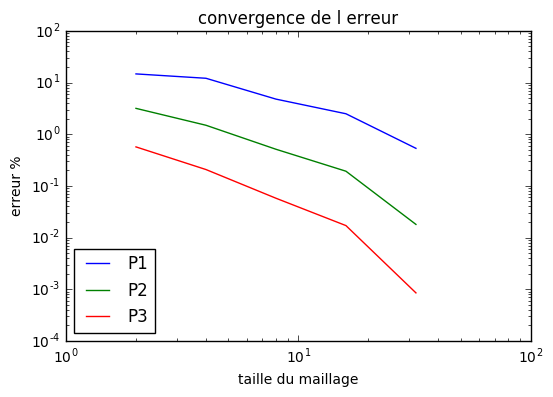

In [13]:
plt.figure(1)
plt.loglog(j[0:5],err[0:5],basex=10,basey=10,label='P1')
plt.loglog(j[0:5],err[6:11],basex=10,basey=10,label='P2')
plt.loglog(j[0:5],err[12:17],basex=10,basey=10,label='P3')
plt.legend(loc=3)
plt.xlabel('taille du maillage')
plt.ylabel('erreur %')
plt.title('convergence de l erreur')
plt.savefig('fig1.png')
plt.show()